<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0811new%5Dmachine_learning_for_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## memory 예측 (점진적 패턴, 느린 주기)

## 복잡한 memory 사용량 형태

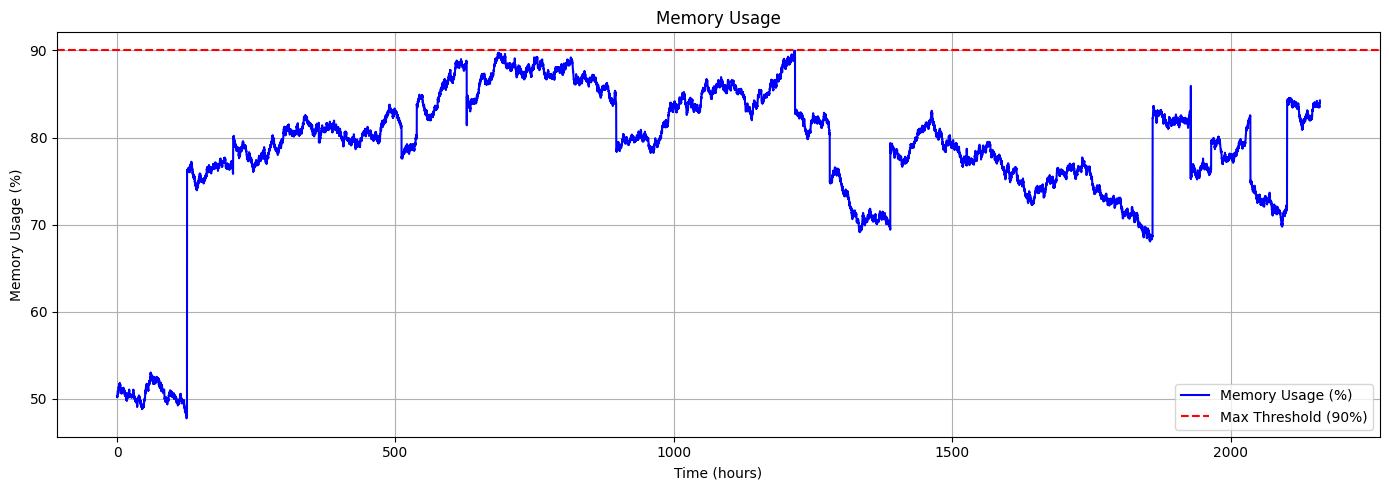

In [2]:
import numpy as np
import matplotlib.pyplot as plt

days = 90
interval_minutes = 5
steps_per_day = int(24 * 60 / interval_minutes)
total_steps = days * steps_per_day
time_hours = np.arange(total_steps) * (interval_minutes / 60)

baseline = 50 + np.random.normal(0, 0.5)  # baseline 자체에 노이즈
threshold = 90
small_noise_std = 0.1
gc_release_range = (5, 15)

# spike 설정
event_spikes = np.zeros(total_steps)
for _ in range(10):
    idx = np.random.randint(0, total_steps - 10)
    duration = np.random.randint(1, 5)
    spike_val = np.random.uniform(10, 60)
    event_spikes[idx:idx+duration] += spike_val

for _ in range(5):
    idx = np.random.randint(0, total_steps - 2)
    spike_val = np.random.uniform(40, 55)
    event_spikes[idx] += spike_val

memory_usage = []
current_mem = baseline

for i in range(total_steps):
    # i 값에 따라 growth_per_step 조정
    if i < total_steps * 0.3:
        growth_per_step = 0.001
    elif i < total_steps * 0.6:
        growth_per_step = 0.002
    else:
        growth_per_step = 0.0005

    current_mem += growth_per_step + np.random.normal(0, small_noise_std) + event_spikes[i]

    # max threshold 초과하지 않도록 제한
    if current_mem > threshold:
        current_mem = threshold

    # GC 작동
    if current_mem >= threshold:
        release_amount = np.random.uniform(*gc_release_range)
        current_mem -= release_amount
        current_mem = max(current_mem, baseline)

    memory_usage.append(current_mem)

memory_usage = np.array(memory_usage)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(time_hours, memory_usage, label="Memory Usage (%)", color='blue')
plt.axhline(threshold, color='red', linestyle='--', label="Max Threshold (90%)")
plt.title("Memory Usage")
plt.xlabel("Time (hours)")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. 노이즈 많은 데이터

업무시간 평균 메모리 사용량   : 48.54%
비업무시간 평균 메모리 사용량 : 44.44%


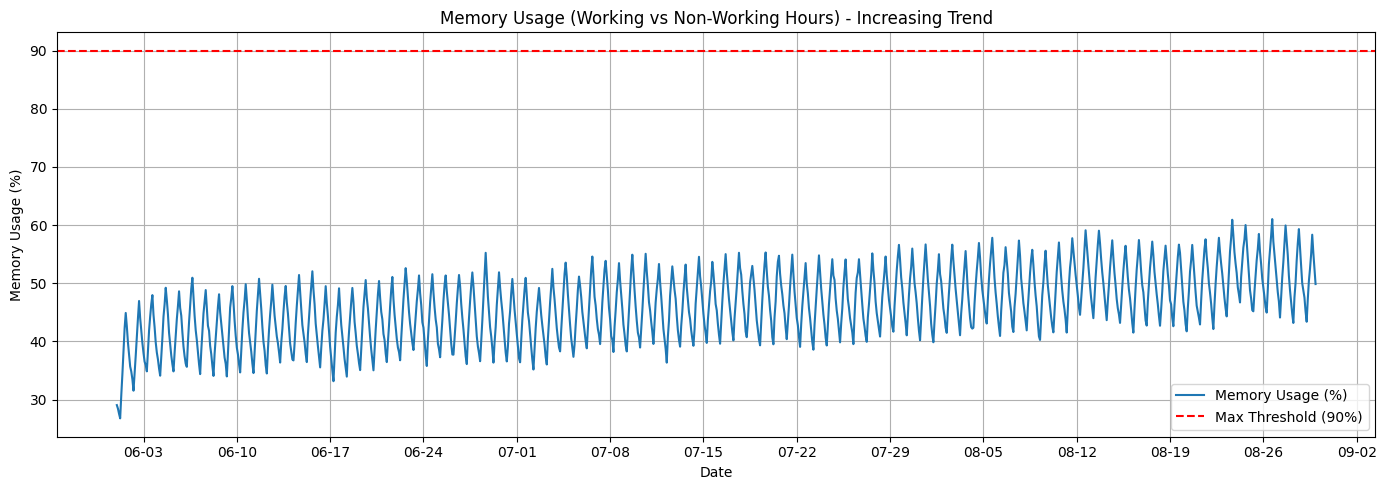

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.1663 - val_loss: 0.0226
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0209
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0200
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202 - val_loss: 0.0156
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.0139
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_l

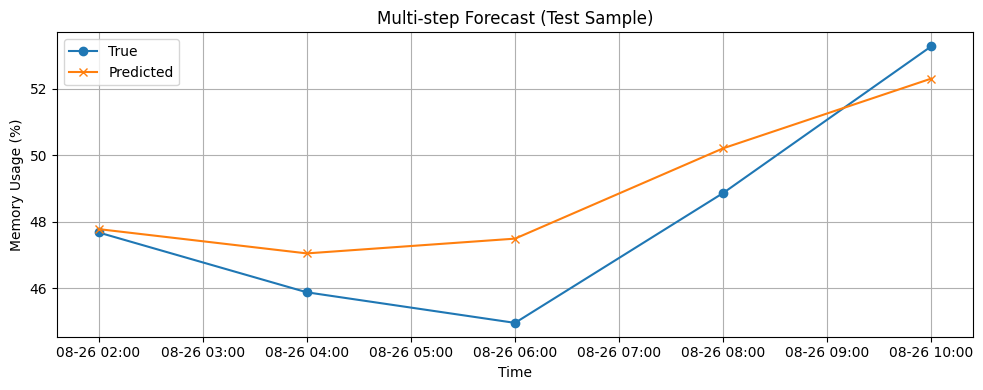

In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# =========================================================
# 0) 시뮬레이션 설정
# =========================================================
np.random.seed(42)

days = 90
interval_minutes = 120  # 데이터 간격(분) — 여기만 바꾸면 전체가 자동 일관
steps_per_day = int(24 * 60 / interval_minutes)
total_steps = days * steps_per_day

start_date = "2025-06-01"
time_index = pd.date_range(start=start_date, periods=total_steps, freq=f"{interval_minutes}min")

threshold = 90
small_noise_std = 0.5
gc_release_range = (5, 15)

# =========================================================
# 1) 메모리 사용량 시뮬레이션
# =========================================================
event_spikes = np.zeros(total_steps)

# 랜덤 스파이크 (이벤트성)
for _ in range(10):
    idx = np.random.randint(0, total_steps - 10)
    duration = np.random.randint(1, 5)
    spike_val = np.random.uniform(10, 60)
    event_spikes[idx:idx+duration] += spike_val

# 단일 순간 스파이크
for _ in range(5):
    idx = np.random.randint(0, total_steps - 2)
    spike_val = np.random.uniform(40, 55)
    event_spikes[idx] += spike_val

memory_usage = []
current_mem = 30.0  # 초기값

for i in range(total_steps):
    hour_of_day = time_index[i].hour

    # 업무시간: 증가 / 비업무: 감소 경향
    if 8 <= hour_of_day < 18:
        growth_per_step = 0.015
        target_level = 70
    else:
        growth_per_step = -0.002
        target_level = 20

    # 장기 증가 추세(최대 +10%)
    trend = i / total_steps * 10.0

    # 노이즈 + 스파이크 반영
    current_mem += growth_per_step + np.random.normal(0, small_noise_std) + event_spikes[i] * 0.02
    # 타겟 레벨로의 완만한 수렴(지수평활 느낌)
    current_mem = current_mem * 0.9 + (target_level + trend) * 0.1

    # 상한선
    if current_mem > threshold:
        current_mem = threshold

    # GC 발생 시 메모리 해제
    if current_mem >= threshold:
        release_amount = np.random.uniform(*gc_release_range)
        current_mem -= release_amount
        current_mem = max(current_mem, target_level)

    memory_usage.append(current_mem)

memory_usage = np.array(memory_usage, dtype=float)

# 길이 검증(중요!)
assert len(time_index) == len(memory_usage), "time_index와 memory_usage 길이가 다릅니다."

# =========================================================
# 2) DataFrame 구성 및 요약 통계
# =========================================================
df = pd.DataFrame({"timestamp": time_index, "memory_usage": memory_usage}).set_index("timestamp")

# 업무/비업무 평균
working_hour_mask = (df.index.hour >= 8) & (df.index.hour < 18)
working_hour_avg = df.loc[working_hour_mask, "memory_usage"].mean()
non_working_hour_avg = df.loc[~working_hour_mask, "memory_usage"].mean()

print(f"업무시간 평균 메모리 사용량   : {working_hour_avg:.2f}%")
print(f"비업무시간 평균 메모리 사용량 : {non_working_hour_avg:.2f}%")

# =========================================================
# 3) 시각화(원 데이터)
# =========================================================
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["memory_usage"], label="Memory Usage (%)")
plt.axhline(threshold, color="red", linestyle="--", label="Max Threshold (90%)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.title("Memory Usage (Working vs Non-Working Hours) - Increasing Trend")
plt.xlabel("Date")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================================================
# 4) 스케일링 및 데이터 분할
# =========================================================
scaler = MinMaxScaler()
mem_scaled = scaler.fit_transform(df[["memory_usage"]].values)  # (N, 1)
mem_scaled = pd.DataFrame(mem_scaled, index=df.index, columns=["memory_usage"])

past_steps = 20
future_steps = 5

n_total = len(mem_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

mem_train = mem_scaled.iloc[:n_train]
mem_val   = mem_scaled.iloc[n_train:n_train+n_val]
mem_test  = mem_scaled.iloc[n_train+n_val:]

# =========================================================
# 5) 시퀀스 생성 함수
#    - 각 subset(Train/Val/Test)에서 독립적으로 시퀀스를 생성
# =========================================================
def create_sequences(df_1col, past_steps=20, future_steps=5):
    """
    df_1col: 1열 DataFrame (index는 datetime)
    Returns:
      X: (samples, past_steps, 1)
      y: (samples, future_steps)
    """
    data = df_1col.values  # (N, 1)
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])                         # (past_steps, 1)
        y.append(data[i+past_steps:i+past_steps+future_steps]) # (future_steps, 1)
    X = np.array(X)
    y = np.array(y).squeeze(-1)
    return X, y

X_train, y_train = create_sequences(mem_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(mem_val,   past_steps, future_steps)
X_test,  y_test  = create_sequences(mem_test,  past_steps, future_steps)

# 방어코드: 시퀀스가 생성되지 않을 정도로 데이터가 짧은지 확인
assert len(X_train) and len(X_val) and len(X_test), "시퀀스가 생성되지 않았습니다. past_steps/future_steps를 줄여보세요."

# =========================================================
# 6) 모델 정의 및 학습 (Conv1D + LSTM)
# =========================================================
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)  # 다단계(5스텝) 예측
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

# =========================================================
# 7) 예측/역스케일 및 성능 평가
# =========================================================
pred = model.predict(X_test)  # (samples, future_steps)
true = y_test                 # (samples, future_steps)

# 역스케일링: 평탄화 → inverse_transform → 원형 복원
pred_inv = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(-1, future_steps)
true_inv = scaler.inverse_transform(true.reshape(-1, 1)).reshape(-1, future_steps)

mae  = mean_absolute_error(true_inv.ravel(), pred_inv.ravel())
rmse = np.sqrt(mean_squared_error(true_inv.ravel(), pred_inv.ravel()))
r2   = r2_score(true_inv.ravel(), pred_inv.ravel())

print("\n=== Test Metrics ===")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²  :", round(r2, 4))

# =========================================================
# 8) 예측 시각화 (테스트 구간 중 임의의 샘플 1개)
#    - 샘플 k에 대해, future_steps 구간의 실제값 vs 예측값 비교
#    - 시간축은 mem_test.index를 사용해 정렬
# =========================================================
k = len(X_test) // 2  # 중간 샘플
start_idx = past_steps + k
end_idx = start_idx + future_steps
ts_window = mem_test.index[start_idx:end_idx]  # 예측 대상 타임스탬프

plt.figure(figsize=(10, 4))
plt.plot(ts_window, true_inv[k], marker='o', label="True")
plt.plot(ts_window, pred_inv[k], marker='x', label="Predicted")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.title("Multi-step Forecast (Test Sample)")
plt.xlabel("Time")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


CNN-LSTM
MAE : 1.597770129327427
RMSE: 1.8923253918862537
R2: 0.8338460992091751


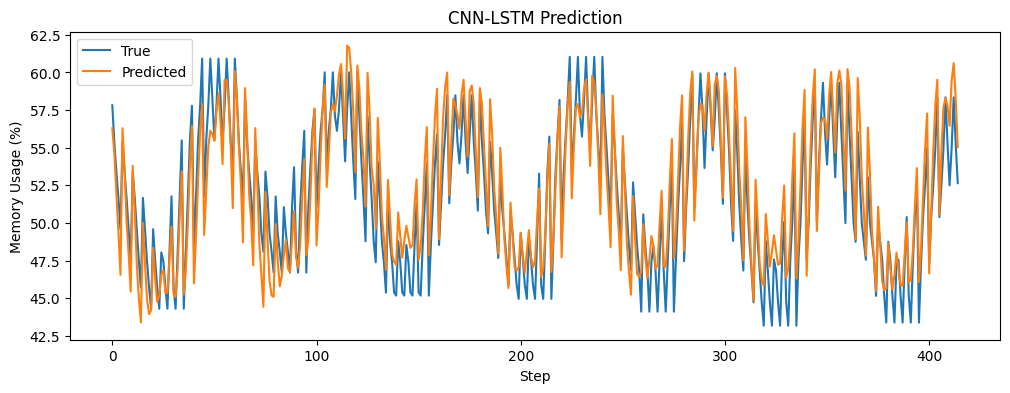

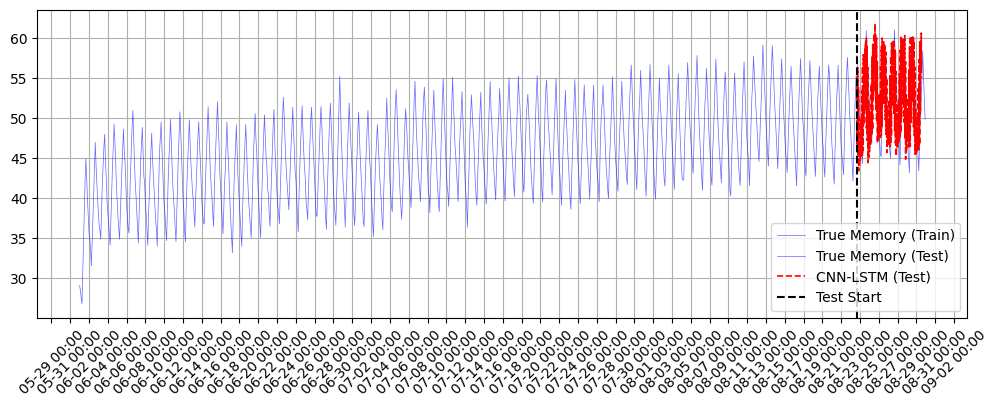

In [4]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory_usage'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory_usage'][train_end:val_end] # validation data
test_series_true= df['memory_usage'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

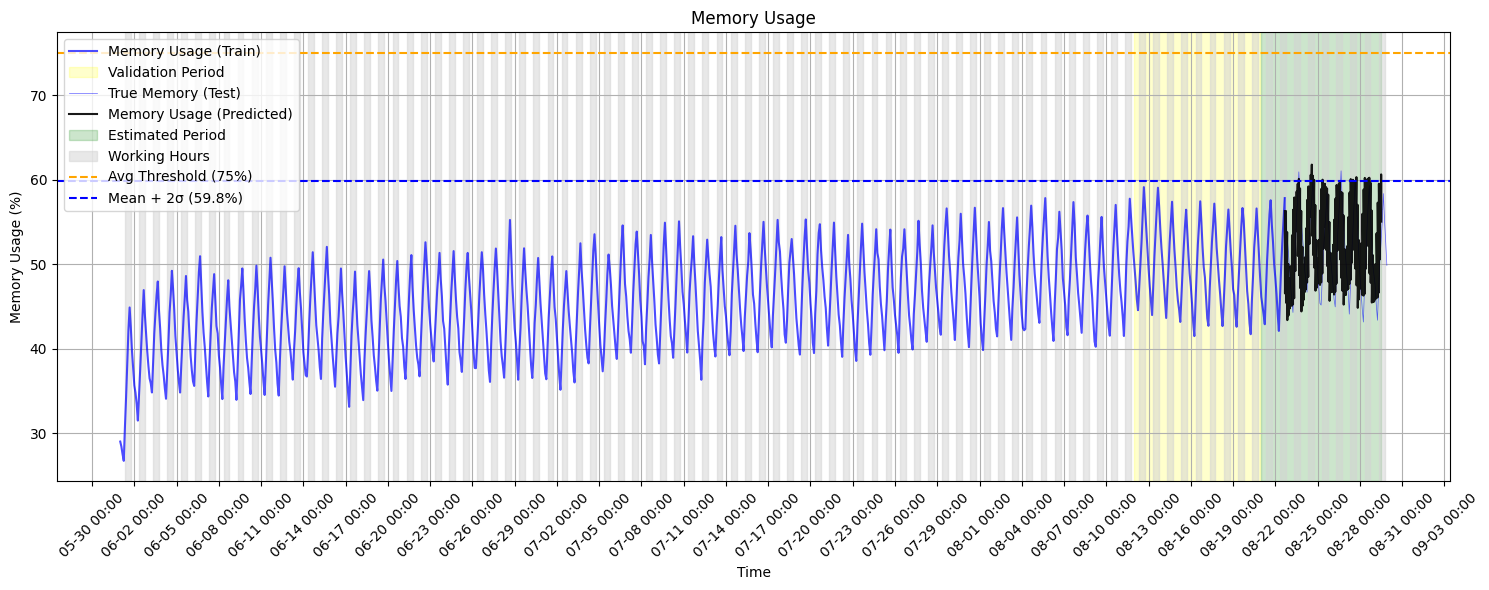

📊 Peak 발생 비율: 6.67%
✅ Peak 기준 만족 여부: True


In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory_usage'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_usage"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 Memory 사용률 ≥ 75% (업무시간, 비업무시간 분리)
avg_threshold = 75
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 조건2 수정 : μ + 2σ 이상 // 90% 이상 중 더 높은 경우를 피크로 간주,  피크 발생한 날이 전체의 80% 이상
# abs_threshold = 90

mu = all_pred_series.mean()
sigma = all_pred_series.std()
rel_threshold = mu + 2 * sigma           # 평균 + 2σ

# peak_threshold = max(abs_threshold, rel_threshold)
daily_peak_flags = all_pred_series > rel_threshold

daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.06   # c등급 피크 비율 6%

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index

elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    # upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
    upgrade_times = work_time[pd.Index(work_time.index.date).isin(peak_day_list)].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory_usage'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
# test_start = test_series_pred.index[0]
# test_end = test_series_pred.index[-1]
test_context_start = mem_test.index[0]   # 컨텍스트 시작
test_pred_start    = test_series_pred.index[0]
test_end           = test_series_pred.index[-1]

ax.axvspan(test_context_start, test_end, color='green', alpha=0.2, label="Estimated Period")
# ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (75%)")
plt.axhline(rel_threshold, color="blue", linestyle="--", label=f"Mean + 2σ ({rel_threshold:.1f}%)")
# plt.axhline(abs_threshold, color="green", linestyle="--", label=f"90th Percentile ({abs_threshold:.1f}%)")
# plt.axhline(peak_threshold, color="red", linestyle="-.", label=f"Mixed Threshold ({peak_threshold:.1f}%)")

# 마무리 설정
ax.set_title("Memory Usage")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# ✅ Peak 기준 값 계산
peak_ratio = (peak_days / total_days) * 100  # 퍼센트(%)

# ✅ 조건 2 결과 출력

print(f"📊 Peak 발생 비율: {peak_ratio:.2f}%")
print(f"✅ Peak 기준 만족 여부: {condition2_flag}")

# streamlit 위한 csv 저장

# 평균 사용률 저장
Memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
Memory_avg_df.to_csv("Memory_avg_usage_CNN-LSTM.csv", index=False)

import json
with open("Memory_accuracy_metrics_CNN-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("Memory_all_series_CNN-LSTM.csv") # 전체 Memory
test_series_pred.to_csv("Memory_usage_predicted_only_CNN-LSTM.csv") # 예측 구간 Memory
work_time.to_csv("Memory_usage_working_hours_CNN-LSTM.csv") # 업무시간 Memory
daily_peak.to_csv("Memory_peak_flag_per_day_CNN-LSTM.csv") # peak 발생 여부

with open("Memory_upgrade_decision_CNN-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("Memory_plot_CNN-LSTM.png")

## 2. CNN

업무시간 평균 메모리 사용량   : 48.54%
비업무시간 평균 메모리 사용량 : 44.44%


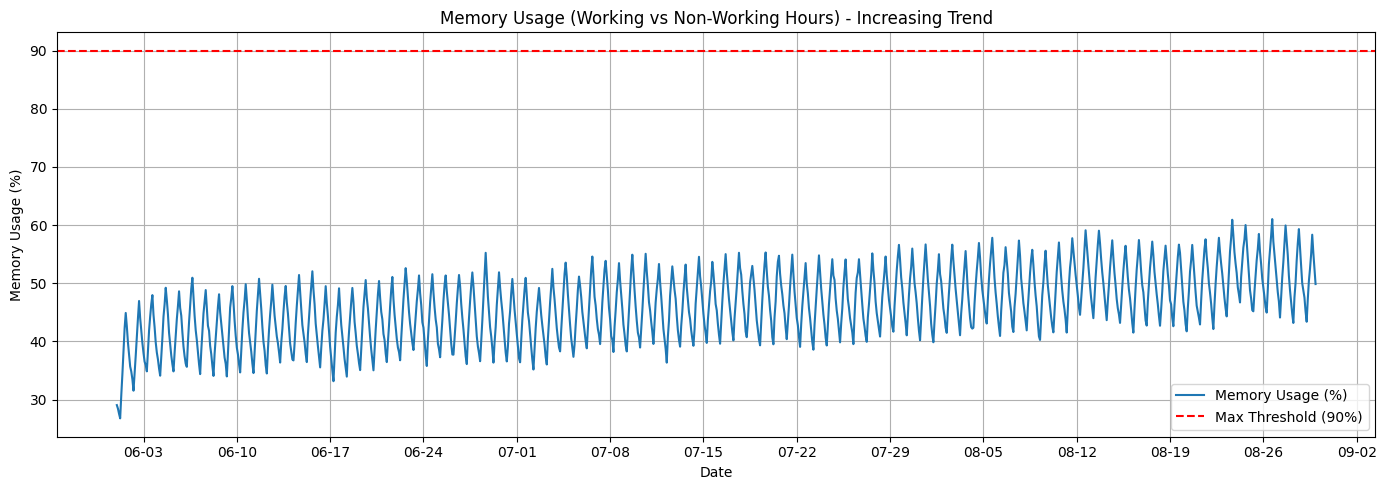

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.2453 - val_loss: 0.2590
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0395 - val_loss: 0.1373
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289 - val_loss: 0.0614
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - val_loss: 0.0364
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.0344
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.0280
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0345
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0312
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0180
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0116
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0095

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step

=== Test Metrics ===
MAE : 2.2058
RMSE: 2.67
R²  : 0.6692


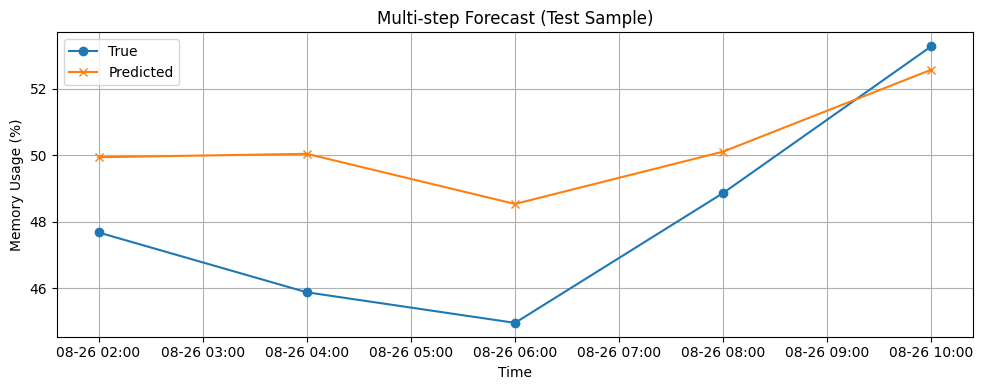

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense



# =========================================================
# 2) DataFrame 구성 및 요약 통계
# =========================================================
df = pd.DataFrame({"timestamp": time_index, "memory_usage": memory_usage}).set_index("timestamp")

# 업무/비업무 평균
working_hour_mask = (df.index.hour >= 8) & (df.index.hour < 18)
working_hour_avg = df.loc[working_hour_mask, "memory_usage"].mean()
non_working_hour_avg = df.loc[~working_hour_mask, "memory_usage"].mean()

print(f"업무시간 평균 메모리 사용량   : {working_hour_avg:.2f}%")
print(f"비업무시간 평균 메모리 사용량 : {non_working_hour_avg:.2f}%")

# =========================================================
# 3) 시각화(원 데이터)
# =========================================================
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["memory_usage"], label="Memory Usage (%)")
plt.axhline(threshold, color="red", linestyle="--", label="Max Threshold (90%)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.title("Memory Usage (Working vs Non-Working Hours) - Increasing Trend")
plt.xlabel("Date")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================================================
# 4) 스케일링 및 데이터 분할
# =========================================================
scaler = MinMaxScaler()
mem_scaled = scaler.fit_transform(df[["memory_usage"]].values)  # (N, 1)
mem_scaled = pd.DataFrame(mem_scaled, index=df.index, columns=["memory_usage"])

past_steps = 20
future_steps = 5

n_total = len(mem_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

mem_train = mem_scaled.iloc[:n_train]
mem_val   = mem_scaled.iloc[n_train:n_train+n_val]
mem_test  = mem_scaled.iloc[n_train+n_val:]

# =========================================================
# 5) 시퀀스 생성 함수
#    - 각 subset(Train/Val/Test)에서 독립적으로 시퀀스를 생성
# =========================================================
def create_sequences(df_1col, past_steps=20, future_steps=5):
    """
    df_1col: 1열 DataFrame (index는 datetime)
    Returns:
      X: (samples, past_steps, 1)
      y: (samples, future_steps)
    """
    data = df_1col.values  # (N, 1)
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])                         # (past_steps, 1)
        y.append(data[i+past_steps:i+past_steps+future_steps]) # (future_steps, 1)
    X = np.array(X)
    y = np.array(y).squeeze(-1)
    return X, y

X_train, y_train = create_sequences(mem_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(mem_val,   past_steps, future_steps)
X_test,  y_test  = create_sequences(mem_test,  past_steps, future_steps)

# 방어코드: 시퀀스가 생성되지 않을 정도로 데이터가 짧은지 확인
assert len(X_train) and len(X_val) and len(X_test), "시퀀스가 생성되지 않았습니다. past_steps/future_steps를 줄여보세요."

# =========================================================
# 6) 모델 정의 및 학습 (CNN-only)
# =========================================================
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),

    GlobalAveragePooling1D(),        # 시계열 축 평균 풀링으로 특징 집약
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(future_steps)              # 멀티스텝 출력
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

# =========================================================
# 7) 예측/역스케일 및 성능 평가
# =========================================================
pred = model.predict(X_test)  # (samples, future_steps)
true = y_test                 # (samples, future_steps)

# 역스케일링: 평탄화 → inverse_transform → 원형 복원
pred_inv = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(-1, future_steps)
true_inv = scaler.inverse_transform(true.reshape(-1, 1)).reshape(-1, future_steps)

mae  = mean_absolute_error(true_inv.ravel(), pred_inv.ravel())
rmse = np.sqrt(mean_squared_error(true_inv.ravel(), pred_inv.ravel()))
r2   = r2_score(true_inv.ravel(), pred_inv.ravel())

print("\n=== Test Metrics ===")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²  :", round(r2, 4))

# =========================================================
# 8) 예측 시각화 (테스트 구간 중 임의의 샘플 1개)
#    - 샘플 k에 대해, future_steps 구간의 실제값 vs 예측값 비교
#    - 시간축은 mem_test.index를 사용해 정렬
# =========================================================
k = len(X_test) // 2  # 중간 샘플
start_idx = past_steps + k
end_idx = start_idx + future_steps
ts_window = mem_test.index[start_idx:end_idx]  # 예측 대상 타임스탬프

plt.figure(figsize=(10, 4))
plt.plot(ts_window, true_inv[k], marker='o', label="True")
plt.plot(ts_window, pred_inv[k], marker='x', label="Predicted")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.title("Multi-step Forecast (Test Sample)")
plt.xlabel("Time")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


CNN
MAE : 2.2058319905724515
RMSE: 2.669963245145419
R2: 0.6692263044667786


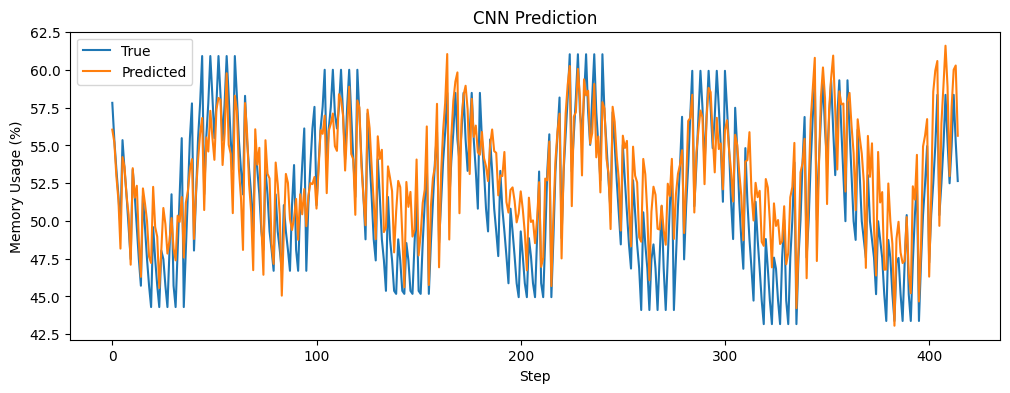

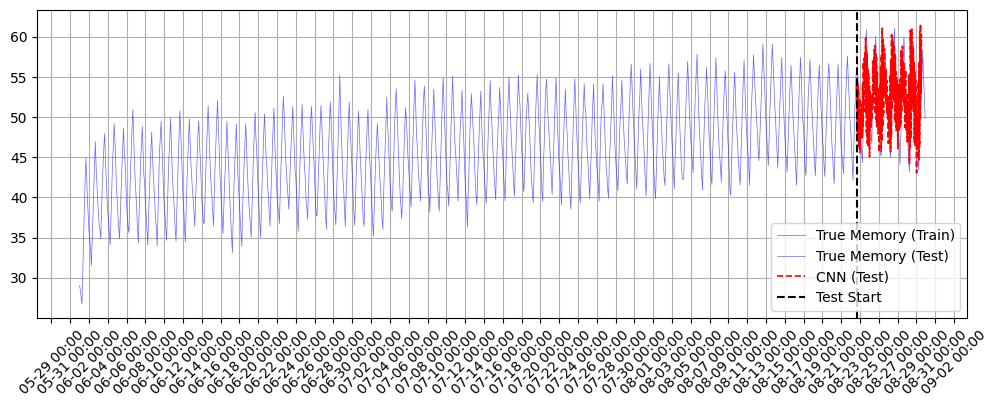

In [9]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory_usage'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory_usage'][train_end:val_end] # validation data
test_series_true= df['memory_usage'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

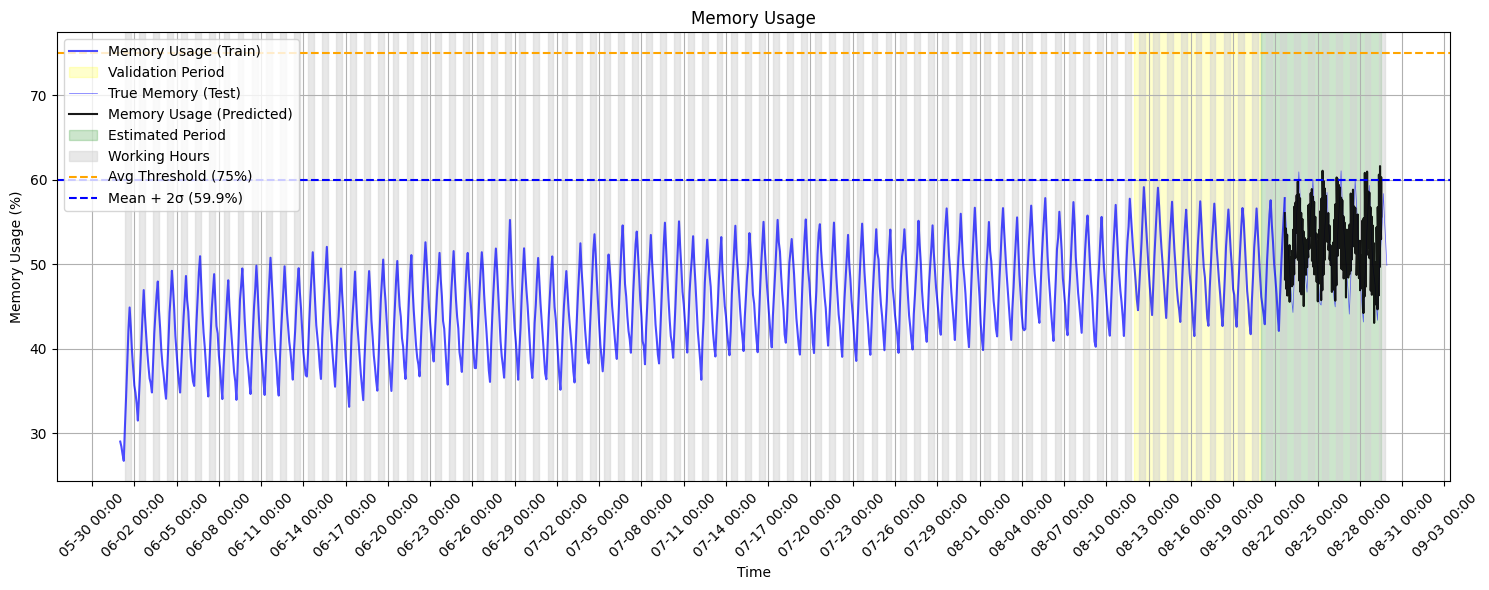

📊 Peak 발생 비율: 4.44%
✅ Peak 기준 만족 여부: False


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory_usage'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_usage"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 Memory 사용률 ≥ 75% (업무시간, 비업무시간 분리)
avg_threshold = 75
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 조건2 수정 : μ + 2σ 이상
mu = all_pred_series.mean()
sigma = all_pred_series.std()
rel_threshold = mu + 2 * sigma           # 평균 + 2σ
daily_peak_flags = all_pred_series > rel_threshold

daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.06   # c등급 피크 비율 6%

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index

elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    # upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
    upgrade_times = work_time[pd.Index(work_time.index.date).isin(peak_day_list)].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory_usage'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
# test_start = test_series_pred.index[0]
# test_end = test_series_pred.index[-1]
test_context_start = mem_test.index[0]   # 컨텍스트 시작
test_pred_start    = test_series_pred.index[0]
test_end           = test_series_pred.index[-1]

ax.axvspan(test_context_start, test_end, color='green', alpha=0.2, label="Estimated Period")
# ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (75%)")
plt.axhline(rel_threshold, color="blue", linestyle="--", label=f"Mean + 2σ ({rel_threshold:.1f}%)")
# plt.axhline(abs_threshold, color="green", linestyle="--", label=f"90th Percentile ({abs_threshold:.1f}%)")
# plt.axhline(peak_threshold, color="red", linestyle="-.", label=f"Mixed Threshold ({peak_threshold:.1f}%)")

# 마무리 설정
ax.set_title("Memory Usage")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# ✅ Peak 기준 값 계산
peak_ratio = (peak_days / total_days) * 100  # 퍼센트(%)

# ✅ 조건 2 결과 출력

print(f"📊 Peak 발생 비율: {peak_ratio:.2f}%")
print(f"✅ Peak 기준 만족 여부: {condition2_flag}")

# streamlit 위한 csv 저장

# 평균 사용률 저장
Memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
Memory_avg_df.to_csv("Memory_avg_usage_CNN.csv", index=False)

import json
with open("Memory_accuracy_metrics_CNN.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("Memory_all_series_CNN.csv") # 전체 Memory
test_series_pred.to_csv("Memory_usage_predicted_only_CNN.csv") # 예측 구간 Memory
work_time.to_csv("Memory_usage_working_hours_CNN.csv") # 업무시간 Memory
daily_peak.to_csv("Memory_peak_flag_per_day_CNN.csv") # peak 발생 여부

with open("Memory_upgrade_decision_CNN.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("Memory_plot_CNN.png")

## Bi-LSTM

업무시간 평균 메모리 사용량   : 48.54%
비업무시간 평균 메모리 사용량 : 44.44%


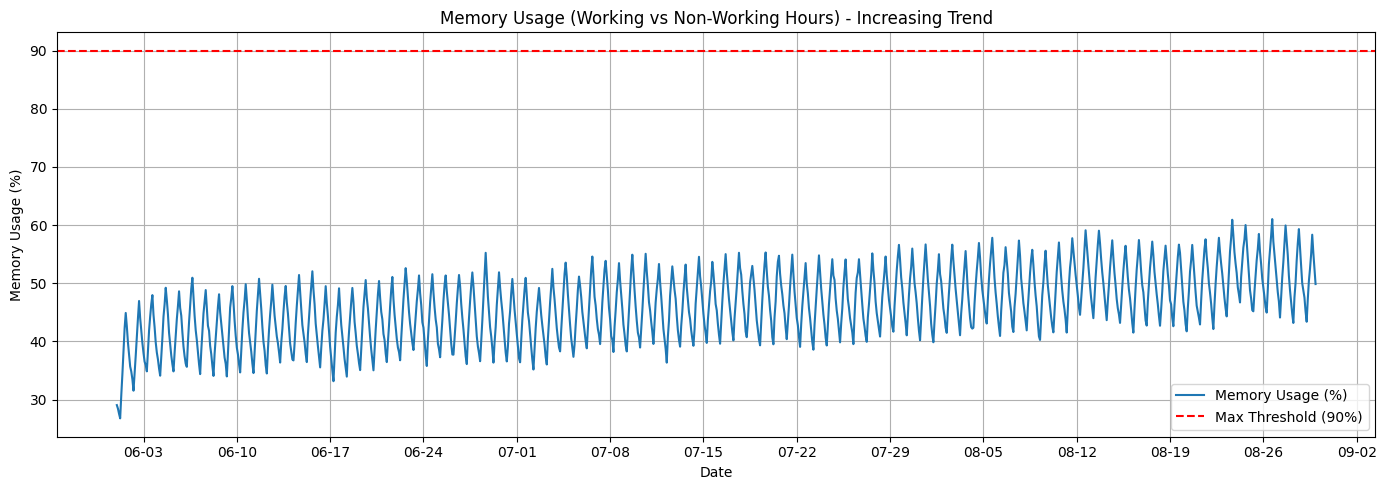

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0645 - val_loss: 0.0183
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0207 - val_loss: 0.0162
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0175 - val_loss: 0.0106
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0109 - val_loss: 0.0031
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - val_loss: 0.0018
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0069 - val_loss: 8.8375e-04
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - val_loss: 8.3958e-04
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0076 - val_loss: 8.3955e-04
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.

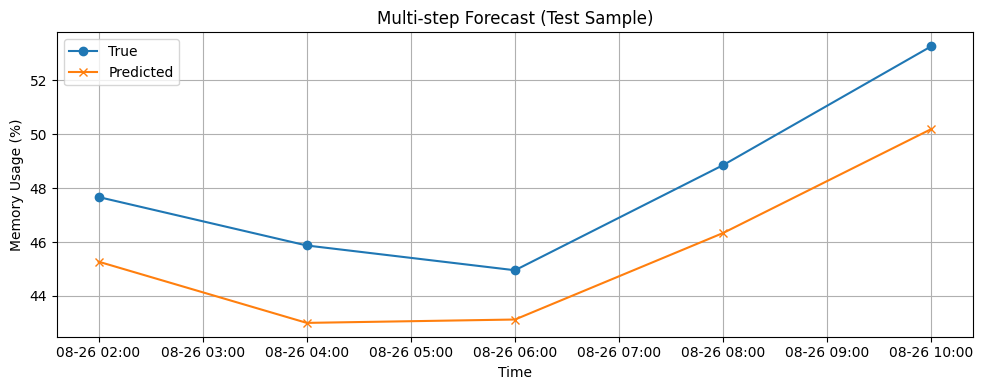

In [11]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense



# =========================================================
# 2) DataFrame 구성 및 요약 통계
# =========================================================
df = pd.DataFrame({"timestamp": time_index, "memory_usage": memory_usage}).set_index("timestamp")

# 업무/비업무 평균
working_hour_mask = (df.index.hour >= 8) & (df.index.hour < 18)
working_hour_avg = df.loc[working_hour_mask, "memory_usage"].mean()
non_working_hour_avg = df.loc[~working_hour_mask, "memory_usage"].mean()

print(f"업무시간 평균 메모리 사용량   : {working_hour_avg:.2f}%")
print(f"비업무시간 평균 메모리 사용량 : {non_working_hour_avg:.2f}%")

# =========================================================
# 3) 시각화(원 데이터)
# =========================================================
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["memory_usage"], label="Memory Usage (%)")
plt.axhline(threshold, color="red", linestyle="--", label="Max Threshold (90%)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.title("Memory Usage (Working vs Non-Working Hours) - Increasing Trend")
plt.xlabel("Date")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================================================
# 4) 스케일링 및 데이터 분할
# =========================================================
scaler = MinMaxScaler()
mem_scaled = scaler.fit_transform(df[["memory_usage"]].values)  # (N, 1)
mem_scaled = pd.DataFrame(mem_scaled, index=df.index, columns=["memory_usage"])

past_steps = 20
future_steps = 5

n_total = len(mem_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

mem_train = mem_scaled.iloc[:n_train]
mem_val   = mem_scaled.iloc[n_train:n_train+n_val]
mem_test  = mem_scaled.iloc[n_train+n_val:]

# =========================================================
# 5) 시퀀스 생성 함수
#    - 각 subset(Train/Val/Test)에서 독립적으로 시퀀스를 생성
# =========================================================
def create_sequences(df_1col, past_steps=20, future_steps=5):
    """
    df_1col: 1열 DataFrame (index는 datetime)
    Returns:
      X: (samples, past_steps, 1)
      y: (samples, future_steps)
    """
    data = df_1col.values  # (N, 1)
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])                         # (past_steps, 1)
        y.append(data[i+past_steps:i+past_steps+future_steps]) # (future_steps, 1)
    X = np.array(X)
    y = np.array(y).squeeze(-1)
    return X, y

X_train, y_train = create_sequences(mem_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(mem_val,   past_steps, future_steps)
X_test,  y_test  = create_sequences(mem_test,  past_steps, future_steps)

# 방어코드: 시퀀스가 생성되지 않을 정도로 데이터가 짧은지 확인
assert len(X_train) and len(X_val) and len(X_test), "시퀀스가 생성되지 않았습니다. past_steps/future_steps를 줄여보세요."
# =========================================================
# 6) 모델 정의 및 학습 (Bi-LSTM)
# =========================================================
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(past_steps, 1)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(future_steps)  # 멀티스텝 출력
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    shuffle=False,        # 시계열이므로 섞지 않음
    verbose=1
)

# =========================================================
# 7) 예측/역스케일 및 성능 평가
# =========================================================
pred = model.predict(X_test)  # (samples, future_steps)
true = y_test                 # (samples, future_steps)

# 역스케일링: 평탄화 → inverse_transform → 원형 복원
pred_inv = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(-1, future_steps)
true_inv = scaler.inverse_transform(true.reshape(-1, 1)).reshape(-1, future_steps)

mae  = mean_absolute_error(true_inv.ravel(), pred_inv.ravel())
rmse = np.sqrt(mean_squared_error(true_inv.ravel(), pred_inv.ravel()))
r2   = r2_score(true_inv.ravel(), pred_inv.ravel())

print("\n=== Test Metrics ===")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²  :", round(r2, 4))

# =========================================================
# 8) 예측 시각화 (테스트 구간 중 임의의 샘플 1개)
#    - 샘플 k에 대해, future_steps 구간의 실제값 vs 예측값 비교
#    - 시간축은 mem_test.index를 사용해 정렬
# =========================================================
k = len(X_test) // 2  # 중간 샘플
start_idx = past_steps + k
end_idx = start_idx + future_steps
ts_window = mem_test.index[start_idx:end_idx]  # 예측 대상 타임스탬프

plt.figure(figsize=(10, 4))
plt.plot(ts_window, true_inv[k], marker='o', label="True")
plt.plot(ts_window, pred_inv[k], marker='x', label="Predicted")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.title("Multi-step Forecast (Test Sample)")
plt.xlabel("Time")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Bi-LSTM
MAE : 1.8968049646730472
RMSE: 2.2986789550960043
R2: 0.7546444813825254


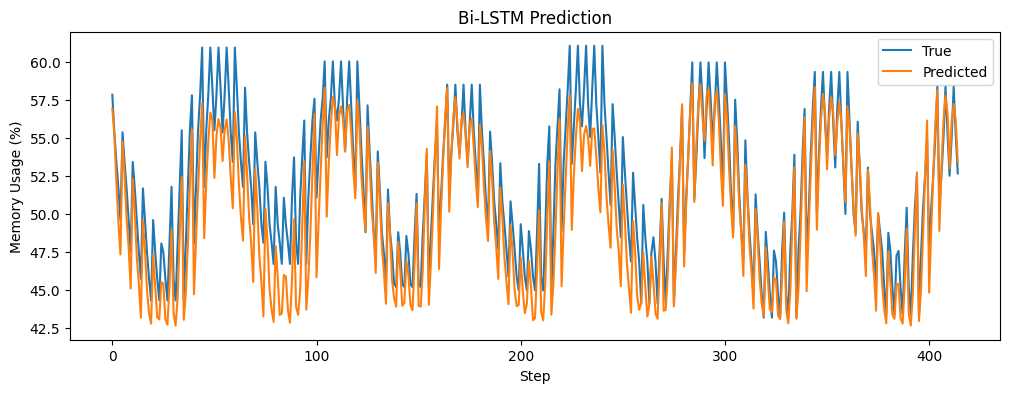

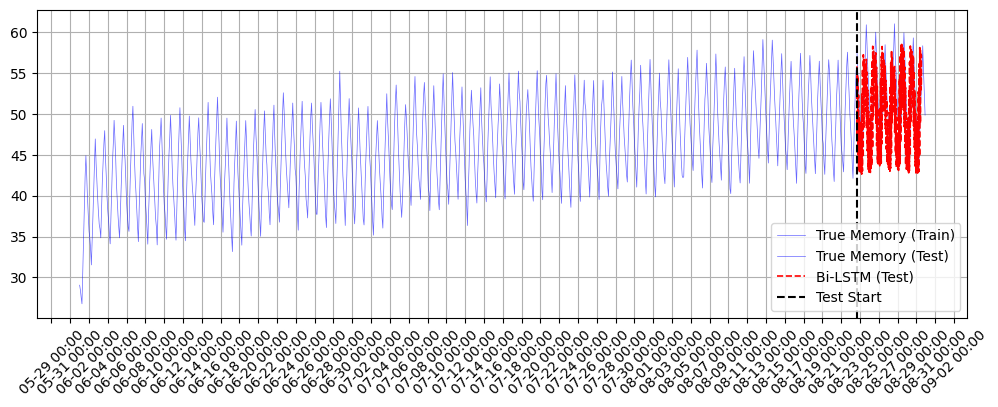

In [12]:
# plot

print("Bi-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("Bi-LSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory_usage'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory_usage'][train_end:val_end] # validation data
test_series_true= df['memory_usage'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="Bi-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

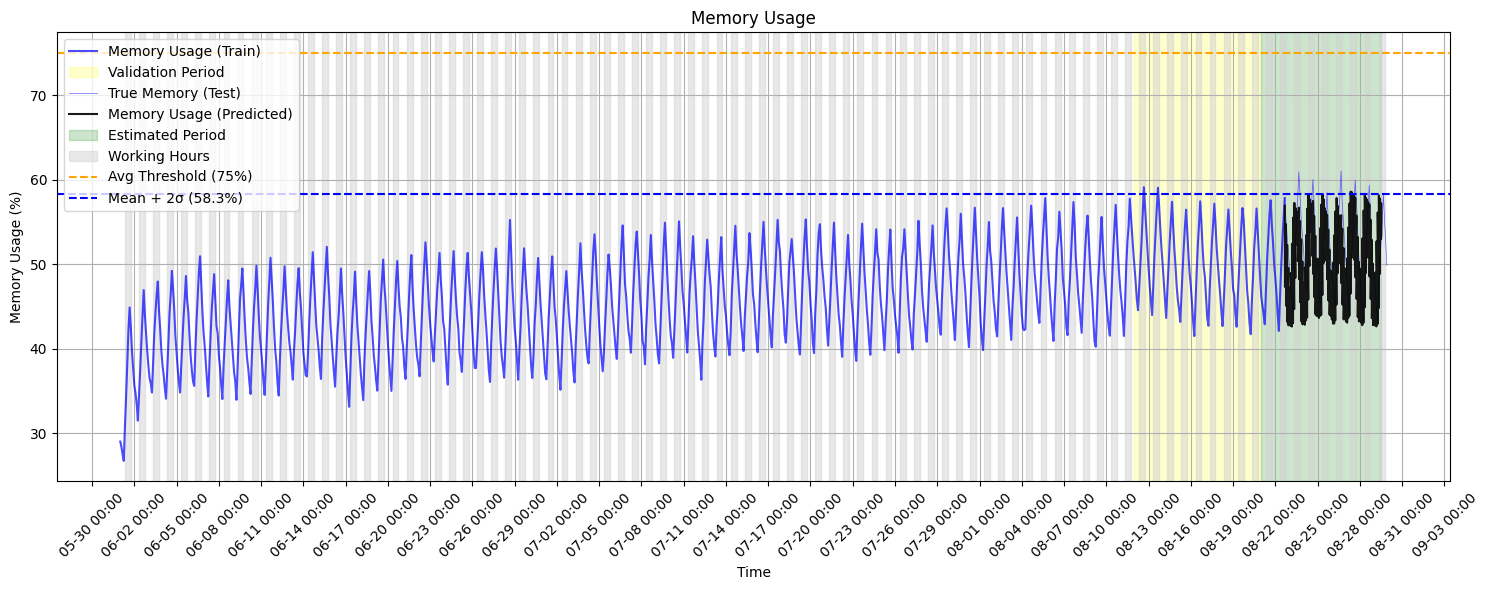

📊 Peak 발생 비율: 5.56%
✅ Peak 기준 만족 여부: False


In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory_usage'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_usage"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 Memory 사용률 ≥ 75% (업무시간, 비업무시간 분리)
avg_threshold = 75
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 조건2 수정 : μ + 2σ 이상
mu = all_pred_series.mean()
sigma = all_pred_series.std()
rel_threshold = mu + 2 * sigma           # 평균 + 2σ
daily_peak_flags = all_pred_series > rel_threshold

daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.06   # c등급 피크 비율 6%

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index

elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    # upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
    upgrade_times = work_time[pd.Index(work_time.index.date).isin(peak_day_list)].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory_usage'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
# test_start = test_series_pred.index[0]
# test_end = test_series_pred.index[-1]
test_context_start = mem_test.index[0]   # 컨텍스트 시작
test_pred_start    = test_series_pred.index[0]
test_end           = test_series_pred.index[-1]

ax.axvspan(test_context_start, test_end, color='green', alpha=0.2, label="Estimated Period")
# ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (75%)")
plt.axhline(rel_threshold, color="blue", linestyle="--", label=f"Mean + 2σ ({rel_threshold:.1f}%)")
# plt.axhline(abs_threshold, color="green", linestyle="--", label=f"90th Percentile ({abs_threshold:.1f}%)")
# plt.axhline(peak_threshold, color="red", linestyle="-.", label=f"Mixed Threshold ({peak_threshold:.1f}%)")

# 마무리 설정
ax.set_title("Memory Usage")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# ✅ Peak 기준 값 계산
peak_ratio = (peak_days / total_days) * 100  # 퍼센트(%)

# ✅ 조건 2 결과 출력

print(f"📊 Peak 발생 비율: {peak_ratio:.2f}%")
print(f"✅ Peak 기준 만족 여부: {condition2_flag}")

# streamlit 위한 csv 저장

# 평균 사용률 저장
Memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
Memory_avg_df.to_csv("Memory_avg_usage_Bi-LSTM.csv", index=False)

import json
with open("Memory_accuracy_metrics_Bi-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("Memory_all_series_Bi-LSTM.csv") # 전체 Memory
test_series_pred.to_csv("Memory_usage_predicted_only_Bi-LSTM.csv") # 예측 구간 Memory
work_time.to_csv("Memory_usage_working_hours_Bi-LSTM.csv") # 업무시간 Memory
daily_peak.to_csv("Memory_peak_flag_per_day_Bi-LSTM.csv") # peak 발생 여부

with open("Memory_upgrade_decision_Bi-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("Memory_plot_Bi-LSTM.png")

## 1. CNN-LSTM 적용 + sliding window(5)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

days = 90
points_per_day = 24 * 12
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'memory': memory_usage}).set_index('timestamp')

scaler = MinMaxScaler()
memory_scaled =pd.DataFrame( scaler.fit_transform(df[['memory']]))

past_steps = 20
future_steps = 5

# ✅ 데이터 분할 (80:10:10)
n_total = len(memory_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

memory_train = memory_scaled.iloc[:n_train]
memory_val   = memory_scaled.iloc[n_train:n_train + n_val]
memory_test  = memory_scaled.iloc[n_train + n_val:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(memory_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(memory_val, past_steps, future_steps)
X_test,  y_test  = create_sequences(memory_test, past_steps, future_steps)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=20, batch_size=16, verbose=1)

pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


ValueError: All arrays must be of the same length

CNN-LSTM
MAE : 0.21592000316009236
RMSE: 0.259587596846048
R²  : 0.9842367662451317


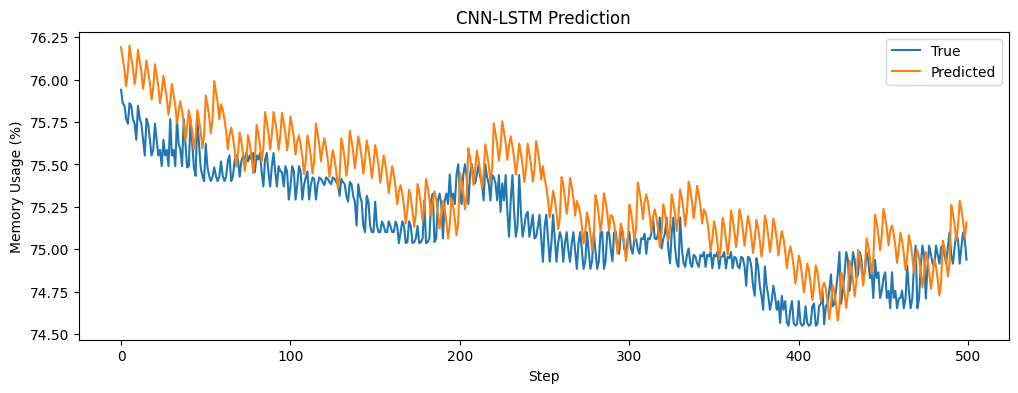

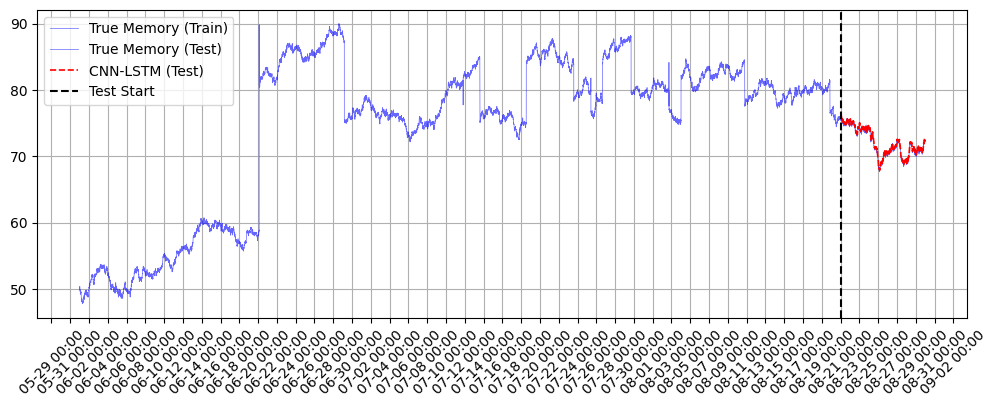

In [ ]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}

plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory'][train_end:val_end] # validation data
test_series_true= df['memory'][test_start_idx:]

all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

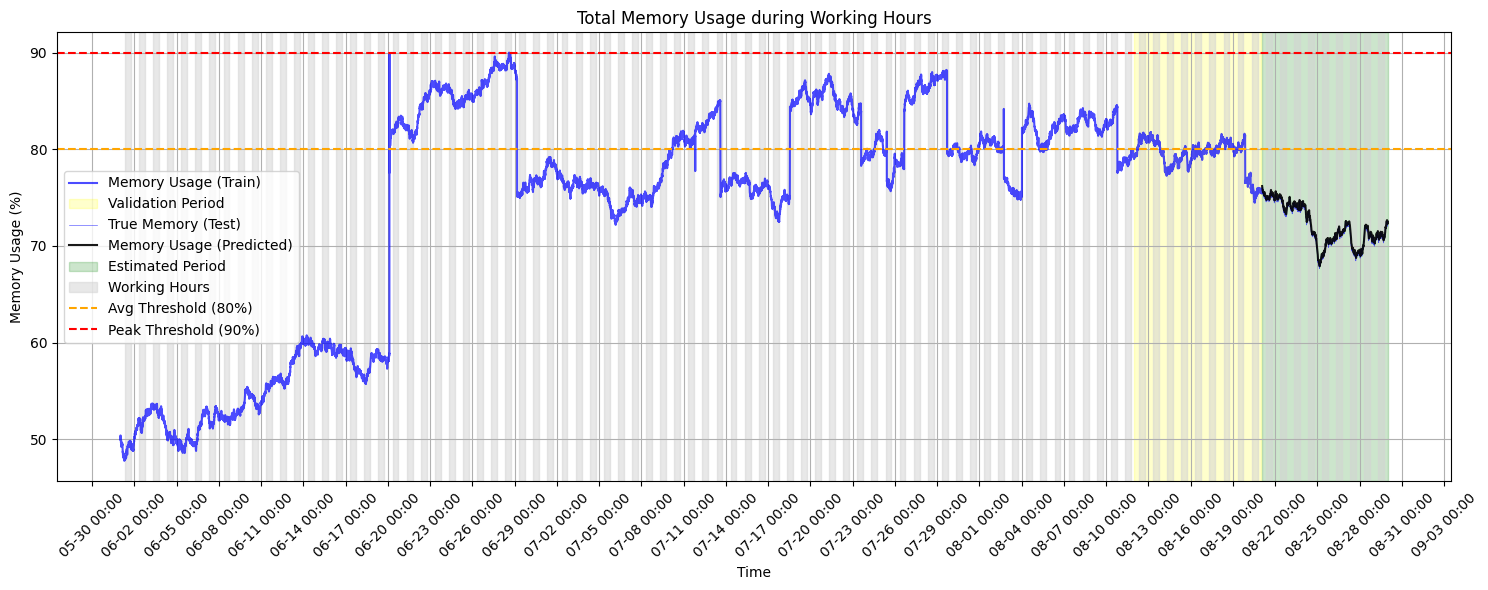

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy.stats import linregress

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 memory 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 메모리 누수 판단
leak_days = []

memory_df = all_pred_series.to_frame(name='memory')
memory_df['date'] = memory_df.index.date
memory_df['hour'] = memory_df.index.hour

unique_dates = sorted(memory_df['date'].unique())

for date in unique_dates:
    nowork_mask = (
        ((memory_df['date'] == date) & (memory_df['hour'] >= 18)) |
        ((memory_df['date'] == pd.to_datetime(date) + pd.Timedelta(days=1)) & (memory_df['hour'] < 8))
    )
    nowork = memory_df[nowork_mask]

    if len(nowork) < 5:
        continue  # 데이터 너무 적으면 skip

    # 선형 회귀로 기울기 확인 → 양수면 증가 추세
    slope, _, _, _, _ = linregress(range(len(nowork)), nowork['memory'].values)

    if slope > 0.01:  # 증가 추세 감지
        leak_days.append(date)

is_memory_leak = len(leak_days) >= 1
print(f"메모리 누수 판단: {is_memory_leak} (감지된 일수: {len(leak_days)})")

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total Memory Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장
memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
memory_avg_df.to_csv("memory_avg_usage_CNN-LSTM.csv", index=False)

import json
with open("memory_accuracy_metrics_CNN-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN-LSTM.csv") # 전체 memory
test_series_pred.to_csv("memory_usage_predicted_only_CNN-LSTM.csv")
work_time.to_csv("memory_usage_working_hours_CNN-LSTM.csv")
daily_peak.to_csv("memory_peak_flag_per_day_CNN-LSTM.csv")

with open("upgrade_decision_CNN-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Memory Leak Detected: {is_memory_leak} (Days: {len(leak_days)})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("memory_plot_CNN-LSTM.png")


## 2. 단순 CNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)


Epoch 1/20
1215/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166

KeyboardInterrupt: 

CNN
MAE : 0.1465744877312432
RMSE: 0.18707748476172667
R²  : 0.9575485399530969


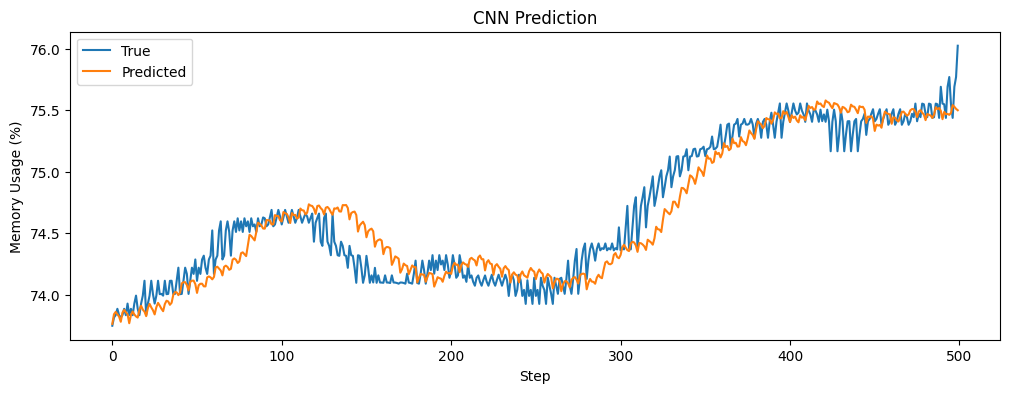

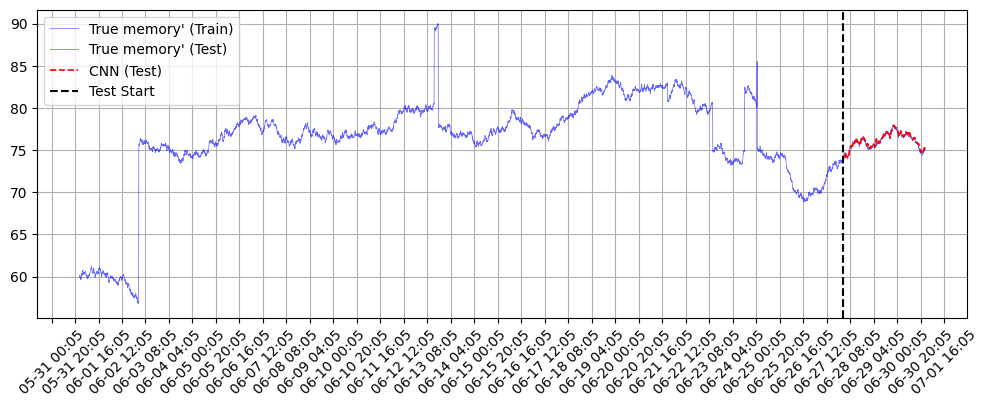

In [ ]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}

plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory'][train_end:val_end] # validation data
test_series_true= df['memory'][test_start_idx:]

all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)

# validation
plt.plot(val_series, label="Validation Memory (Val)", color="blue", alpha = 0.4, linewidth = 0.5)
# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")


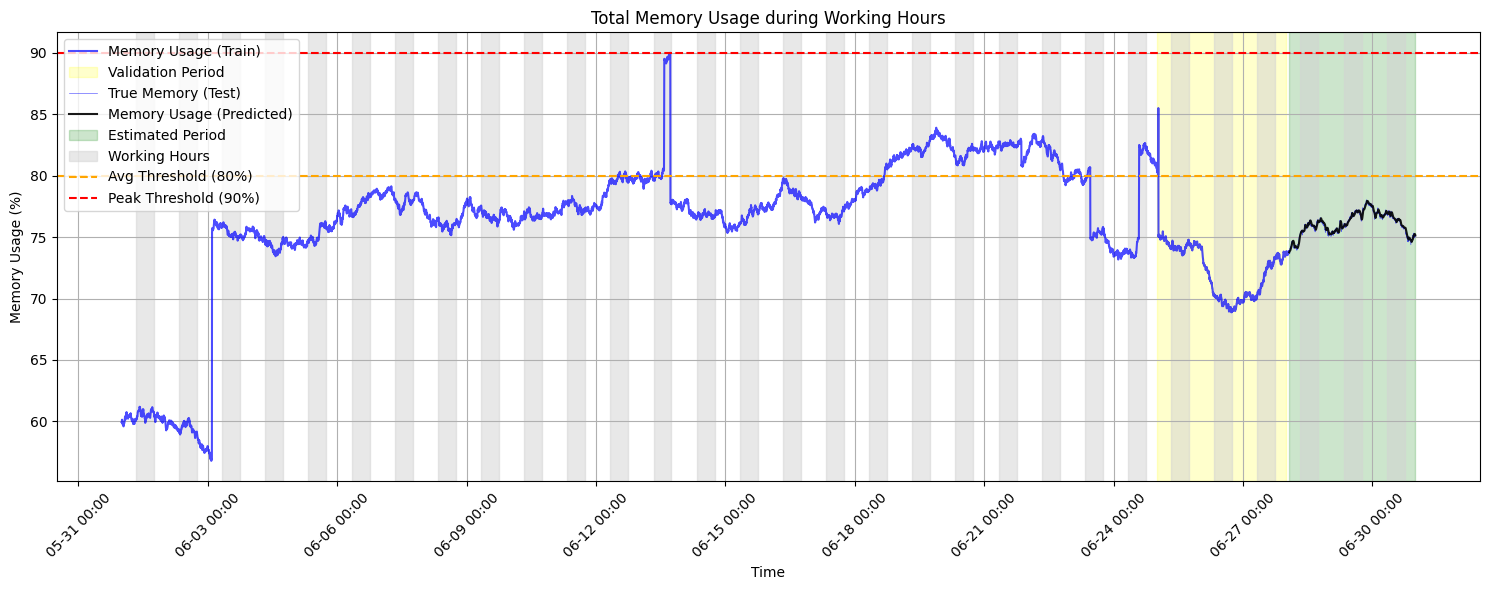

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 memory 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 메모리 누수 판단
leak_days = []

memory_df = all_pred_series.to_frame(name='memory')
memory_df['date'] = memory_df.index.date
memory_df['hour'] = memory_df.index.hour

unique_dates = sorted(memory_df['date'].unique())

for date in unique_dates:
    nowork_mask = (
        ((memory_df['date'] == date) & (memory_df['hour'] >= 18)) |
        ((memory_df['date'] == pd.to_datetime(date) + pd.Timedelta(days=1)) & (memory_df['hour'] < 8))
    )
    nowork = memory_df[nowork_mask]

    if len(nowork) < 5:
        continue  # 데이터 너무 적으면 skip

    # 선형 회귀로 기울기 확인 → 양수면 증가 추세
    slope, _, _, _, _ = linregress(range(len(nowork)), nowork['memory'].values)

    if slope > 0.01:  # 증가 추세 감지
        leak_days.append(date)

is_memory_leak = len(leak_days) >= 1
print(f"메모리 누수 판단: {is_memory_leak} (감지된 일수: {len(leak_days)})")


# # 6. Upgrade 표시할 시간대 지정
# if condition1_flag:
#     upgrade_times = work_time.index
# elif condition2_flag:
#     # 조건 2 충족 시 peak 발생일 기준
#     peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
#     upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
# else:
#     upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total Memory Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장
memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
memory_avg_df.to_csv("memory_avg_usage_CNN.csv", index=False)

import json
with open("memory_accuracy_metrics_CNN.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN.csv") # 전체 memory
test_series_pred.to_csv("memory_usage_predicted_only_CNN.csv")
work_time.to_csv("memory_usage_working_hours_CNN.csv")
daily_peak.to_csv("memory_peak_flag_per_day_CNN.csv")

with open("upgrade_decision_CNN.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("memory_plot_CNN.png")


## CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

In [ ]:
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ✅ CNN-BiLSTM 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ✅ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ✅ 학습
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ✅ 예측
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ✅ 복원 (정규화 → 원래 단위 [%]로)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ✅ 성능 출력
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0280
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.4808e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.7699e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.4956e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 6.4483e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.5771e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6222e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5397e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.8263e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.5624e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.7970e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4378e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.4409e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.0713e-04
Epoch

CNN-BiLSTM
MAE : 0.2306473860744897
RMSE: 0.4232804044999631
R²  : 0.8451819465035728


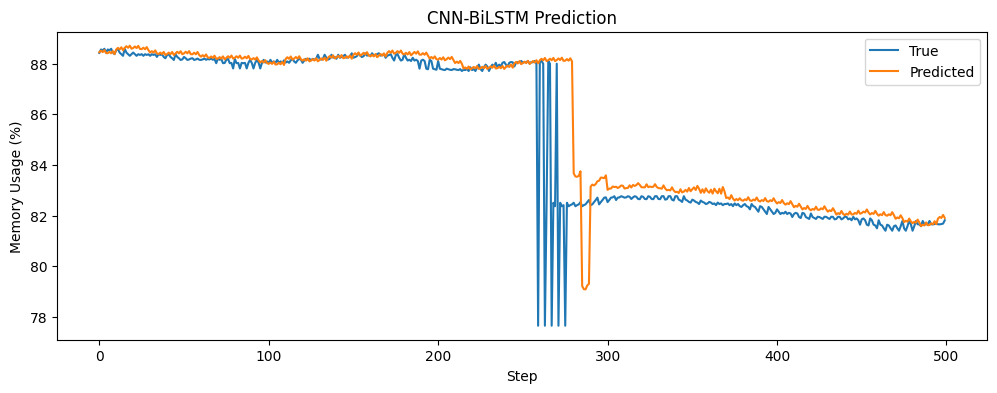

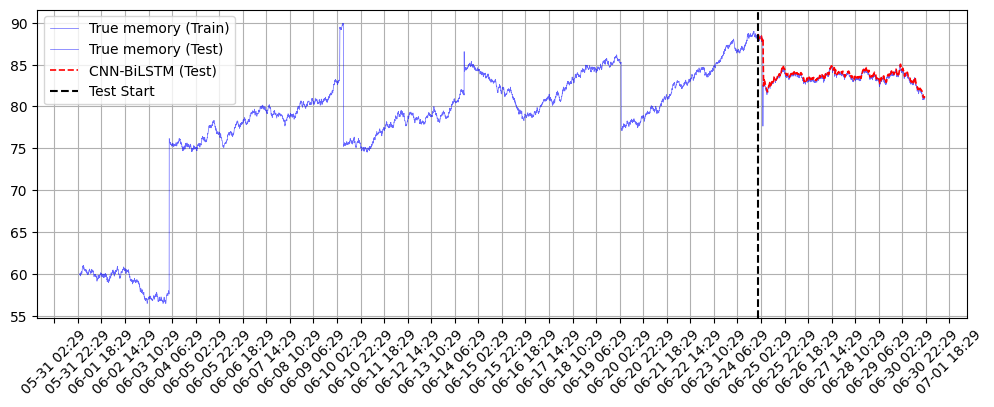

In [ ]:
# plot

print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))
metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-BiLSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)

test_start_idx = val_end + past_steps
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
val_series = df['memory'][train_end:val_end] # validation data
test_series_true= df['memory'][test_start_idx:]

all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)

# validation
plt.plot(val_series, label="Validation Memory (Val)", color="blue", alpha = 0.4, linewidth = 0.5)
# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="Bi-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 memory 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 메모리 누수 판단
leak_days = []

memory_df = all_pred_series.to_frame(name='memory')
memory_df['date'] = memory_df.index.date
memory_df['hour'] = memory_df.index.hour

unique_dates = sorted(memory_df['date'].unique())

for date in unique_dates:
    nowork_mask = (
        ((memory_df['date'] == date) & (memory_df['hour'] >= 18)) |
        ((memory_df['date'] == pd.to_datetime(date) + pd.Timedelta(days=1)) & (memory_df['hour'] < 8))
    )
    nowork = memory_df[nowork_mask]

    if len(nowork) < 5:
        continue  # 데이터 너무 적으면 skip

    # 선형 회귀로 기울기 확인 → 양수면 증가 추세
    slope, _, _, _, _ = linregress(range(len(nowork)), nowork['memory'].values)

    if slope > 0.01:  # 증가 추세 감지
        leak_days.append(date)

is_memory_leak = len(leak_days) >= 1
print(f"메모리 누수 판단: {is_memory_leak} (감지된 일수: {len(leak_days)})")

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total Memory Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장
memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
memory_avg_df.to_csv("memory_avg_usage_Bi-LSTM.csv", index=False)

import json
with open("memory_accuracy_metrics_Bi-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_Bi-LSTM.csv") # 전체 memory
test_series_pred.to_csv("memory_usage_predicted_only_Bi-LSTM.csv")
work_time.to_csv("memory_usage_working_hours_Bi-LSTM.csv")
daily_peak.to_csv("memory_peak_flag_per_day_Bi-LSTM.csv")

with open("upgrade_decision_Bi-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("memory_plot_Bi-LSTM.png")


## app.py 에서 memory 함수만

In [ ]:
def show_memory_analysis():
# 이상적인 데이터

        st.markdown("#### 1. 이상적인 데이터")

        with st.expander("학습모델 : CNN-LSTM"):
            st.markdown("#### 학습모델 : CNN-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("memory/Memory_all_series_CNN-LSTM.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("memory/Memory_usage_predicted_only_CNN-LSTM.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("memory/Memory_usage_working_hours_CNN-LSTM.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("memory/Memory_peak_flag_per_day_CNN-LSTM.csv", index_col=0, parse_dates=True)

            avg_threshold = 75

            # 정확도
            with open("memory/Memory_accuracy_metrics_CNN-LSTM.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("memory/Memory_avg_usage_CNN-LSTM.csv")

            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_memory_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_memory_ideal >= avg_threshold

            series = pd.read_csv(
                "memory/Memory_all_series_CNN-LSTM.csv",
                index_col=0, parse_dates=True
            )['memory_usage']

            mu = float(series.mean())
            sigma = float(series.std())
            rel_threshold = mu + 2 * sigma

            daily_peak_flags = series > rel_threshold
            daily_peak = daily_peak_flags.groupby(series.index.date).any()
            peak_days = int(daily_peak.sum())
            total_days = int(len(daily_peak))
            condition2_flag = (peak_days / total_days) >= 0.06  # C등급 6%

            upgrade_ideal = condition1_ideal or condition2_flag

            st.markdown("#### ⚙️ 평균 Memory 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 Memory 누설 판단")
            try:
                from scipy.stats import linregress
                _HAS_SCIPY = True
            except Exception:
                _HAS_SCIPY = False

            def detect_memory_leak_segmented(memory_df: pd.DataFrame,
                                            work_start="08:00",
                                            work_end="18:00",
                                            slope_threshold=0.0,
                                            min_points=5):
                """비업무 시간(18~익일 08시) 구간별 선형 회귀 기울기가 양수면 누수로 간주"""
                df = memory_df.copy()
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                unique_days = pd.Index(sorted(pd.to_datetime(df.index.date).unique()))
                rows, leak_days = [], []

                ws_h = int(work_start.split(":")[0])  # 8
                we_h = int(work_end.split(":")[0])    # 18

                for d in unique_days[:-1]:  # 마지막 날은 다음날 08:00이 없을 수 있음
                    start = pd.Timestamp(d) + pd.Timedelta(hours=we_h)                  # d 18:00
                    end   = pd.Timestamp(d) + pd.Timedelta(days=1) + pd.Timedelta(hours=ws_h)  # d+1 08:00

                    seg = df.loc[(df.index >= start) & (df.index < end), "memory"]
                    if len(seg) < min_points:
                        continue

                    x = (seg.index - seg.index[0]).total_seconds() / 3600.0  # 시간 단위
                    y = seg.values.astype(float)

                    if _HAS_SCIPY:
                        slope, intercept, r, p, stderr = linregress(x, y)
                    else:
                        # SciPy 없는 환경 fallback
                        slope = np.polyfit(x, y, 1)[0]
                        r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
                        p = np.nan
                        stderr = np.nan

                    is_leak = slope > slope_threshold
                    rows.append({
                        "date": d,
                        "start": start,
                        "end": end,
                        "slope(%/h)": slope,
                        "r": r,
                        "p": p,
                        "is_leak": is_leak
                    })
                    if is_leak:
                        leak_days.append(d)

                detail = pd.DataFrame(rows)
                return {"is_memory_leak": len(leak_days) > 0, "leak_days": leak_days, "detail": detail}

            # --- 실행: 위에서 만든 series 사용 ---
            memory_df_for_leak = series.to_frame(name="memory")   # series: 전체 시계열 (index=datetime, column='memory_usage')
            memory_df_for_leak.rename(columns={"memory_usage": "memory"}, inplace=True)

            leak_res = detect_memory_leak_segmented(
                memory_df_for_leak,
                work_start="08:00",
                work_end="18:00",
                slope_threshold=0.0,  # 필요시 양수 조금(예: 0.01)로 조정
                min_points=5
            )

            is_leak = leak_res["is_memory_leak"]
            leak_days = leak_res["leak_days"]
            detail = leak_res["detail"]

            st.markdown(f"- **메모리 누수 감지 여부**: `{is_leak}` (감지 일수: **{len(leak_days)}**)")

            if not detail.empty:
                # 보기 좋게 포맷
                detail_show = detail.copy()
                detail_show["date"] = detail_show["date"].astype(str)
                detail_show = detail_show[["date", "start", "end", "slope(%/h)", "r", "p", "is_leak"]]
                st.dataframe(
                    detail_show.style.format({
                        "slope(%/h)": "{:.3f}",
                        "r": "{:.3f}",
                        "p": "{:.3f}"
                    }),
                    use_container_width=True
                )

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : C등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 75%): <code>{condition1_ideal}</code> ({avg_memory_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 6%): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("memory/Memory_plot_CNN-LSTM.png") # fig 파일


        # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_CNN.png") # fig 파일

        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 조건 재계산
            avg_cpu_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM.png") # fig 파일


        # 2. 노이즈 많은 데이터

        # --- 파일 불러오기 ---
        df_all = pd.read_csv("cpu/all_series_CNN-LSTM2.csv", index_col=0, parse_dates=True)
        df_pred = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM2.csv", index_col=0, parse_dates=True)
        df_work = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM2.csv", index_col=0, parse_dates=True)
        df_peak = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN-LSTM2.csv", index_col=0, parse_dates=True)


        # --- 조건 재계산 ---
        avg_threshold = 80
        peak_threshold = 90

        avg_cpu = df_work.values.mean()
        condition1_flag = avg_cpu >= avg_threshold

        peak_days = df_peak.values.sum()
        total_days = len(df_peak)
        condition2_flag = (peak_days / total_days) >= 0.8

        upgrade_flag = condition1_flag or condition2_flag

        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

        # 정확도 불러오기
        with open("cpu/cpu_accuracy_metrics_CNN-LSTM2.json", "r") as f:
            metrics = json.load(f)

        # --- 업그레이드 표시 시간 추출 ---
        if condition1_flag:
            upgrade_times = df_work.index
        elif condition2_flag:
            peak_day_list = df_peak[df_peak.values.flatten()].index[:5]
            upgrade_times = df_work[df_work.index.date.astype(str).isin(peak_day_list.astype(str))].index
        else:
            upgrade_times = []

        # --- Streamlit 출력 ---

        st.markdown("#### 2. 노이즈 많은 데이터")
        with st.expander("학습모델 : CNN-LSTM"):
          st.markdown("#### 학습모델 : CNN-LSTM")

          # 표시
          df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM2.csv")
          avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
          avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

          # 조건 재계산
          avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
          condition1_ideal = avg_cpu_ideal >= avg_threshold

          peak_days_ideal = df_peak_ideal.values.sum()
          total_days_ideal = len(df_peak_ideal)
          condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

          upgrade_ideal = condition1_ideal or condition2_ideal

          st.markdown("#### ⚙️ 평균 CPU 사용률")
          st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
          st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
          focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
          focus_value = max(avg_work, avg_nowork)
          st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

          st.markdown("#### 📊 예측 정확도")
          st.markdown(f"- **MAE**: {metrics['MAE']}")
          st.markdown(f"- **RMSE**: {metrics['RMSE']}")
          st.markdown(f"- **R² Score**: {metrics['R2']}")

          st.markdown("#### 🔍 증설 판단")
          st.markdown("#### 시스템 중요도 : A등급")
          st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 CPU 사용량 ≥ 70%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
          st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

          # 결과 강조
          result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
          st.markdown(f"<h4>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)
          st.image("cpu/cpu_plot_CNN-LSTM2.png") # fig 파일

        # CNN
        with st.expander("학습모델 : CNN"):
          st.markdown("#### 학습모델 : CNN")

          # --- 파일 불러오기 ---
          df_all = pd.read_csv("cpu/all_series_CNN2.csv", index_col=0, parse_dates=True)
          df_pred = pd.read_csv("cpu/cpu_usage_predicted_only_CNN2.csv", index_col=0, parse_dates=True)
          df_work = pd.read_csv("cpu/cpu_usage_working_hours_CNN2.csv", index_col=0, parse_dates=True)
          df_peak = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN2.csv", index_col=0, parse_dates=True)

          from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

          # 정확도 불러오기
          with open("cpu/cpu_accuracy_metrics_CNN2.json", "r") as f:
              metrics = json.load(f)

          # 표시
          df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN2.csv")
          avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
          avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

          # 조건 재계산
          avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
          condition1_ideal = avg_cpu_ideal >= avg_threshold

          peak_days_ideal = df_peak_ideal.values.sum()
          total_days_ideal = len(df_peak_ideal)
          condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

          upgrade_ideal = condition1_ideal or condition2_ideal

          st.markdown("#### ⚙️ 평균 CPU 사용률")
          st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
          st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
          focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
          focus_value = max(avg_work, avg_nowork)
          st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

          st.markdown("#### 📊 예측 정확도")
          st.markdown(f"- **MAE**: {metrics['MAE']}")
          st.markdown(f"- **RMSE**: {metrics['RMSE']}")
          st.markdown(f"- **R² Score**: {metrics['R2']}")

          st.markdown("#### 🔍 증설 판단")
          st.markdown("#### 시스템 중요도 : A등급")
          st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 CPU 사용량 ≥ 70%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
          st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

          # 결과 강조
          result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
          st.markdown(f"<h4>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)

          st.image("cpu/cpu_plot_CNN2.png") # fig 파일


        # Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM2.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM2.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM2.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM2.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 조건 재계산
            avg_cpu_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM2.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM2.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            mu = all_pred_series.mean()
            sigma = all_pred_series.std()
            rel_threshold = mu + 2 * sigma           # 평균 + 2σ

            daily_peak_flags = all_pred_series > rel_threshold

            daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
            peak_days = daily_peak.sum()
            total_days = len(daily_peak)
            condition2_flag = (peak_days / total_days) >= 0.06   # c등급 피크 비율 6%

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM2.png") # fig 파일

      # 3. 증설 필요한 데이터

        st.markdown("#### 3. 증설 필요한 데이터")

        with st.expander("학습모델 : CNN-LSTM"):
            st.markdown("#### 학습모델 : CNN-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN-LSTM3.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM3.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM3.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN-LSTM3.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN-LSTM3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM3.csv")

            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_CNN-LSTM3.png") # fig 파일

        # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN3.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN3.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN3.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN3.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN3.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)
            st.image("cpu/cpu_plot_CNN3.png") # fig 파일

        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM3.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM3.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM3.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM3.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 조건 재계산
            avg_cpu_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM3.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM3.png") # fig 파일

      # 4. 축소 필요한 데이터

        st.markdown("#### 4. 증설 필요한 데이터")

        with st.expander("학습모델 : CNN-LSTM"):
            st.markdown("#### 학습모델 : CNN-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN-LSTM4.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM4.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM4.csv", index_col=0, parse_dates=True)

            avg_threshold = 30
            std_threshold = 5  # C등급 기준: 표준편차 5% 이하

            # 평균 사용률 조건
            avg_cpu_ideal = max(avg_work, avg_nowork)
            condition1_ideal = avg_cpu_ideal <= avg_threshold

            # 표준편차 계산
            std_cpu_ideal = df_all_ideal['cpu'].std()
            condition2_ideal = std_cpu_ideal <= std_threshold

            # 축소 판단
            shrink_ideal = condition1_ideal and condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 축소 판단")
            st.markdown("#### 시스템 중요도 : C등급")

            # 조건 1: 평균 사용률
            st.markdown(
                f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≤ 30%): "
                f"<code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True
            )

            # 조건 2: 표준편차
            st.markdown(
                f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 표준편차 ≤ 5%): "
                f"<code>{condition2_ideal}</code> ({std_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True
            )

            # 최종 판단 출력
            result_text_ideal = '🟩 <b>축소 권고</b>' if shrink_ideal else '🟥 <b>축소 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h4>", unsafe_allow_html=True)


            st.image("cpu/cpu_plot_CNN-LSTM4.png") # fig 파일

        # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN4.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN4.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN4.csv", index_col=0, parse_dates=True)

            avg_threshold = 30  # 평균 사용률 기준 (C등급)
            std_threshold = 5   # 표준편차 기준 (C등급)

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN4.json", "r") as f:
                metrics_ideal = json.load(f)

            # 평균 사용률 계산
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN4.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]
            avg_cpu_ideal = max(avg_work, avg_nowork)
            condition1_ideal = avg_cpu_ideal <= avg_threshold

            # 표준편차 계산
            std_cpu_ideal = df_all_ideal['cpu'].std()
            condition2_ideal = std_cpu_ideal <= std_threshold

            # 축소 최종 판단
            shrink_ideal = condition1_ideal and condition2_ideal

            # UI 출력
            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 축소 판단")
            st.markdown("#### 시스템 중요도 : C등급")

            st.markdown(
                f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≤ 30%): "
                f"<code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            st.markdown(
                f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 표준편차 ≤ 5%): "
                f"<code>{condition2_ideal}</code> ({std_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            result_text_ideal = '🟩 <b>축소 권고</b>' if shrink_ideal else '🟥 <b>축소 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h4>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_CNN4.png")  # 시각화


        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM4.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM4.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM4.csv", index_col=0, parse_dates=True)

            avg_threshold = 30  # 평균 사용률 축소 기준 (C등급)
            std_threshold = 5   # 표준편차 축소 기준 (C등급)

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM4.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work, avg_nowork)
            condition1_ideal = avg_cpu_ideal <= avg_threshold

            std_cpu_ideal = df_all_ideal['cpu'].std()
            condition2_ideal = std_cpu_ideal <= std_threshold

            shrink_ideal = condition1_ideal and condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 축소 판단")
            st.markdown("#### 시스템 중요도 : C등급")

            st.markdown(
                f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≤ 30%): "
                f"<code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            st.markdown(
                f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 표준편차 ≤ 5%): "
                f"<code>{condition2_ideal}</code> ({std_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            result_text_ideal = '🟩 <b>축소 권고</b>' if shrink_ideal else '🟥 <b>축소 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h4>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM4.png")  # fig 파일


      # pdf 생성
        from fpdf import FPDF

        st.markdown("---")
        st.markdown("### 📝 PDF 보고서 만들기")

        # --- 체크박스 선택
        include_accuracy = st.checkbox("모델별 예측 정확도 포함", value=True)
        include_conditions = st.checkbox("증설 및 축소 조건 판단 포함", value=True)
        include_chart = st.checkbox("CPU 사용량 그래프 포함", value=True)






                # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("memory/Memory_all_series_CNN.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("memory/Memory_usage_predicted_only_CNN.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("memory/Memory_usage_working_hours_CNN.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("memory/Memory_peak_flag_per_day_CNN.csv", index_col=0, parse_dates=True)

            avg_threshold = 75

            # 정확도
            with open("memory/Memory_accuracy_metrics_CNN.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("memory/Memory_avg_usage_CNN.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_memory_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_memory_ideal >= avg_threshold

            series = pd.read_csv(
                "memory/Memory_all_series_CNN.csv",
                index_col=0, parse_dates=True
            )['memory_usage']

            mu = float(series.mean())
            sigma = float(series.std())
            rel_threshold = mu + 2 * sigma

            daily_peak_flags = series > rel_threshold
            daily_peak = daily_peak_flags.groupby(series.index.date).any()
            peak_days = int(daily_peak.sum())
            total_days = int(len(daily_peak))
            condition2_flag = (peak_days / total_days) >= 0.07  # C등급 7%

            upgrade_ideal = condition1_ideal or condition2_flag


            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")


            st.markdown("#### 🔍 Memory 누설 판단")
            try:
                from scipy.stats import linregress
                _HAS_SCIPY = True
            except Exception:
                _HAS_SCIPY = False

            def detect_memory_leak_segmented(memory_df: pd.DataFrame,
                                            work_start="08:00",
                                            work_end="18:00",
                                            slope_threshold=0.05,      # ← 기준 기울기( %/h )
                                            min_points=5,
                                            required_fraction=0.7):    # ← 전체 야간 중 만족 비율
                """비업무 시간(18~익일 08시)마다 선형회귀 기울기를 계산하고,
                  기울기 ≥ slope_threshold를 만족한 밤이 전체의 required_fraction 이상이면 누수로 판정."""
                df = memory_df.copy()
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                unique_days = pd.Index(sorted(pd.to_datetime(df.index.date).unique()))
                rows, leak_days = [], []

                ws_h = int(work_start.split(":")[0])  # 8
                we_h = int(work_end.split(":")[0])    # 18

                nights_valid = 0
                nights_flagged = 0

                for d in unique_days[:-1]:  # 마지막 날은 다음날 08:00이 없을 수 있음
                    start = pd.Timestamp(d) + pd.Timedelta(hours=we_h)                  # d 18:00
                    end   = pd.Timestamp(d) + pd.Timedelta(days=1) + pd.Timedelta(hours=ws_h)  # d+1 08:00

                    seg = df.loc[(df.index >= start) & (df.index < end), "memory"]
                    if len(seg) < min_points:
                        continue

                    nights_valid += 1

                    x = (seg.index - seg.index[0]).total_seconds() / 3600.0  # 시간(시간 단위)
                    y = seg.values.astype(float)

                    try:
                        from scipy.stats import linregress
                        slope, intercept, r, p, stderr = linregress(x, y)
                    except Exception:
                        # SciPy 없는 환경 fallback
                        slope = np.polyfit(x, y, 1)[0]
                        r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
                        p = np.nan
                        stderr = np.nan

                    meets = slope >= slope_threshold
                    if meets:
                        nights_flagged += 1
                        leak_days.append(d)

                    rows.append({
                        "date": d,
                        "start": start,
                        "end": end,
                        "slope(%/h)": slope,
                        "r": r,
                        "p": p,
                        "meets_threshold": meets
                    })

                detail = pd.DataFrame(rows)
                leak_ratio = (nights_flagged / nights_valid) if nights_valid > 0 else 0.0
                is_memory_leak = leak_ratio >= required_fraction

                return {
                    "is_memory_leak": is_memory_leak,
                    "leak_days": leak_days,
                    "detail": detail,
                    "nights_valid": nights_valid,
                    "nights_flagged": nights_flagged,
                    "leak_ratio": leak_ratio
                }


            # --- 실행: 위에서 만든 series 사용 ---
            memory_df_for_leak = series.to_frame(name="memory")   # series: 전체 시계열
            leak_res = detect_memory_leak_segmented(
                memory_df_for_leak,
                work_start="08:00",
                work_end="18:00",
                slope_threshold=0.05,   # 기울기 기준
                min_points=5,
                required_fraction=0.7   # 야간의 70% 이상
            )

            is_leak   = leak_res["is_memory_leak"]
            detail    = leak_res["detail"]
            ratio_pct = leak_res["leak_ratio"] * 100

            st.markdown(
                f"- **메모리 누수 감지 여부**: `{is_leak}` "
                f"(기준 충족 밤: **{leak_res['nights_flagged']}/{leak_res['nights_valid']}**, "
                f"비율: **{ratio_pct:.1f}%**)"
            )
            if not detail.empty:
                st.dataframe(detail.style.format({"slope(%/h)": "{:.3f}", "r": "{:.3f}", "p": "{:.3f}"}),
                            use_container_width=True)


            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : C등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 75%): <code>{condition1_ideal}</code> ({avg_memory_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 7%): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("memory/Memory_plot_CNN.png") # fig 파일

        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("memory/Memory_all_series_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("memory/Memory_usage_predicted_only_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("memory/Memory_usage_working_hours_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("memory/Memory_peak_flag_per_day_Bi-LSTM.csv", index_col=0, parse_dates=True)

            avg_threshold = 75

            # 조건 재계산
            avg_memory_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_memory_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            series = pd.read_csv(
                "memory/Memory_all_series_Bi-LSTM.csv",
                index_col=0, parse_dates=True
            )['memory_usage']

            mu = float(series.mean())
            sigma = float(series.std())
            rel_threshold = mu + 2 * sigma

            daily_peak_flags = series > rel_threshold
            daily_peak = daily_peak_flags.groupby(series.index.date).any()
            peak_days = int(daily_peak.sum())
            total_days = int(len(daily_peak))
            condition2_flag = (peak_days / total_days) >= 0.07  # C등급 7%

            upgrade_ideal = condition1_ideal or condition2_flag


            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")


            st.markdown("#### 🔍 Memory 누설 판단")
            try:
                from scipy.stats import linregress
                _HAS_SCIPY = True
            except Exception:
                _HAS_SCIPY = False

            def detect_memory_leak_segmented(memory_df: pd.DataFrame,
                                            work_start="08:00",
                                            work_end="18:00",
                                            slope_threshold=0.05,      # ← 기준 기울기( %/h )
                                            min_points=5,
                                            required_fraction=0.7):    # ← 전체 야간 중 만족 비율
                """비업무 시간(18~익일 08시)마다 선형회귀 기울기를 계산하고,
                  기울기 ≥ slope_threshold를 만족한 밤이 전체의 required_fraction 이상이면 누수로 판정."""
                df = memory_df.copy()
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                unique_days = pd.Index(sorted(pd.to_datetime(df.index.date).unique()))
                rows, leak_days = [], []

                ws_h = int(work_start.split(":")[0])  # 8
                we_h = int(work_end.split(":")[0])    # 18

                nights_valid = 0
                nights_flagged = 0

                for d in unique_days[:-1]:  # 마지막 날은 다음날 08:00이 없을 수 있음
                    start = pd.Timestamp(d) + pd.Timedelta(hours=we_h)                  # d 18:00
                    end   = pd.Timestamp(d) + pd.Timedelta(days=1) + pd.Timedelta(hours=ws_h)  # d+1 08:00

                    seg = df.loc[(df.index >= start) & (df.index < end), "memory"]
                    if len(seg) < min_points:
                        continue

                    nights_valid += 1

                    x = (seg.index - seg.index[0]).total_seconds() / 3600.0  # 시간(시간 단위)
                    y = seg.values.astype(float)

                    try:
                        from scipy.stats import linregress
                        slope, intercept, r, p, stderr = linregress(x, y)
                    except Exception:
                        # SciPy 없는 환경 fallback
                        slope = np.polyfit(x, y, 1)[0]
                        r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
                        p = np.nan
                        stderr = np.nan

                    meets = slope >= slope_threshold
                    if meets:
                        nights_flagged += 1
                        leak_days.append(d)

                    rows.append({
                        "date": d,
                        "start": start,
                        "end": end,
                        "slope(%/h)": slope,
                        "r": r,
                        "p": p,
                        "meets_threshold": meets
                    })

                detail = pd.DataFrame(rows)
                leak_ratio = (nights_flagged / nights_valid) if nights_valid > 0 else 0.0
                is_memory_leak = leak_ratio >= required_fraction

                return {
                    "is_memory_leak": is_memory_leak,
                    "leak_days": leak_days,
                    "detail": detail,
                    "nights_valid": nights_valid,
                    "nights_flagged": nights_flagged,
                    "leak_ratio": leak_ratio
                }

            # --- 실행: 위에서 만든 series 사용 ---
            memory_df_for_leak = series.to_frame(name="memory")   # series: 전체 시계열
            leak_res = detect_memory_leak_segmented(
                memory_df_for_leak,
                work_start="08:00",
                work_end="18:00",
                slope_threshold=0.05,   # 기울기 기준
                min_points=5,
                required_fraction=0.7   # 야간의 70% 이상
            )

            is_leak   = leak_res["is_memory_leak"]
            detail    = leak_res["detail"]
            ratio_pct = leak_res["leak_ratio"] * 100

            st.markdown(
                f"- **메모리 누수 감지 여부**: `{is_leak}` "
                f"(기준 충족 밤: **{leak_res['nights_flagged']}/{leak_res['nights_valid']}**, "
                f"비율: **{ratio_pct:.1f}%**)"
            )
            if not detail.empty:
                st.dataframe(detail.style.format({"slope(%/h)": "{:.3f}", "r": "{:.3f}", "p": "{:.3f}"}),
                            use_container_width=True)


            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : C등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 75%): <code>{condition1_ideal}</code> ({avg_memory_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 7%): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("memory/Memory_plot_Bi-LSTM.png") # fig 파일
